In [1]:
#import packages we need
import imageio
import numpy as np
import scipy.linalg as la
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

In [2]:
def dYdt(Y,t):
    n = len(Y)
    phi = Y[0:int(n/2)] #we know n is even since Y = [phi phidot]
    phidot = Y[int(n/2):n]
    
    #get rod tip data (pos vel acc)
    xt = getxt(t)
    yt = getyt(t)
    xtdot = getxtdot(t)
    ytdot = getytdot(t)
    xtddot = getxtddot(t)
    ytddot = getytddot(t)
    
    
    #build RHS vector Q
    Q = build_Q(phi, phidot, m, L, r, xt, yt, xtdot, ytdot, xtddot, ytddot)
    
    #matrix [I 0;0 ainv]  #see eqn 32 of wang paper
    M = np.zeros((n,n))
    for i in range(n//2):
        M[i,i] = 1.
    
    #build little a, then invert and put into M
    #a needs to be n/2 by n/2 np.array/matrix
    A = build_bigA(phi,phidot,m) #called twice (revise later)
    a = build_a(phi,phidot,A,L,m)
    ainv = la.inv(a)
    
    for i in range(n//2):
        M[n//2+i,n//2+i] = ainv[i,i]
    
    b = np.zeros((n,1))
    for i in range(n//2):
        b[i] = phidot[i]
        b[n//2+i] = Q[i]
    Ydot = M@b
    
    return Ydot.flatten()

In [3]:
#helper routines to build RHS vectors and matrices

def build_Q(phi, phidot, m, L, r, xt, yt, xtdot, ytdot, xtddot, ytddot):
    n = len(phi)
    Q = np.zeros((n, 1))
    g = 9.8
    rhoa = 0.0
    CS = 0.005

    A = build_bigA(phi, phidot, m)

    for i in range(n):
        s = m[i]*0.5*L[i]*(g*np.cos(phi[i])-np.sin(phi[i])
                            * xtddot+np.cos(phi[i])*ytddot)
        for k in range(i, n):
            if k != i:
                s += m[k]*L[i]*(g*np.cos(phi[i])-np.sin(phi[i])
                                * xtddot+np.cos(phi[i])*ytddot)
        Q[i] = -s

        s = 0
        for k in range(i, n):
            if k != i:
                s += A[i, k]*L[i]*L[k]*phidot[k]**2*np.sin(phi[k]-phi[i])
        Q[i] += s

        # cos(phi[k] - phi[i]) = 1 when i = k therefore cos is not needed
        s = getCD(getRe(phi, phidot, i, r, L, xtdot, ytdot)) * \
            rhoa*r[i]*L[i]*getViD(xtdot, ytdot, phi[i]) * \
            np.abs(getViD(xtdot, ytdot, phi[i]))*0.5*L[i]
        
        for k in range(i, n):
            if k != i:              
                s += getCD(getRe(phi, phidot, k, r, L, xtdot, ytdot)) * \
                    rhoa*r[k]*L[k]*getViD(xtdot, ytdot, phi[k]) * \
                    np.abs(getViD(xtdot, ytdot, phi[k]))*L[i]*np.cos(phi[k]-phi[i])
        Q[i] += -s

        # sin(phi[i] - phi[k]) = 0 when i = k therefore s = 0
        s = 0
        for k in range(i, n):
            if k != i:
                s += CS*rhoa*np.pi * \
                    r[k]*L[k]*getViS(xtdot, ytdot, phi[k]) * \
                    np.abs(getViS(xtdot, ytdot, phi[k]))*L[i]*np.sin(phi[i]-phi[k])
        Q[i] += -s

    return Q



def build_a(phi,phidot,A,L,m):
    #build little a matrix from wang paper
    #m is vector of segment masses
    #L is vector of segment lengths
    #A is big A matrix 
    n = len(phi)
    a = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i == j:
                s = m[j]*L[j]*L[j]*0.25
                for k in range(i,n):
                    s+= m[k]*L[k]*L[k]
                a[i,j] = s
            else:
                a[i,j] = A[i,j]*L[i]*L[j]*np.cos(phi[i]-phi[j])
    return a

def build_bigA(phi,phidot,m):
    #build big A matrix from wang paper
    #m is vector of masses of segments
    n = len(phi)
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if j>i:
                s = 0
                for k in range(j,n):
                    s += m[k] - 0.5*m[j]
                A[i,j] = s
            else:
                s = 0
                for k in range(i,n):
                    s += m[k] - 0.5*m[i]
                A[i,j] = s
    return A

In [4]:
#Reynolds number, drag, and dissipation calculations

def getRe(phi,phidot,i,r,L,xtdot,ytdot):
    #return the Reynolds number for segment i
    #r is the radius of the segment
    #L is a vector of segment lengths
    Re = 0.
    Re = 1.364e5*r[i]*np.sqrt(getxdot(phi,phidot,i,xtdot,L)**2 + getydot(phi,phidot,i,ytdot,L)**2)
    return Re

def getCD(Re):
    #return drag coefficient in normal direction
    #Re is Reynolds number
    CD = 0.
    if Re < 1:
        return 7.16
    if Re < 34:
        return 7.16*Re**-0.42
    if Re < 1580:
        return 3.02*Re**-0.165
    else:
        return 0.9
    return CD
#note CS = 0.005 constant dont need a function here

In [5]:
#routines to get positions and velocities

def getx(phi,i,xt,L):
    #get x at position i
    #rod tip x coordinate at xt
    #L is vector of segment Lengths
    s = xt
    for j in range(i-1):
        s += L[j]*np.cos(phi[j])
    s+= L[i]*np.cos(phi[i])*0.5 
    return s

def gety(phi,i,yt,L):
    #get y at position i
    #rod tip y coordinate at yt
    #L is vector of segment Lengths
    s = yt
    for j in range(i-1):
        s += L[j]*np.sin(phi[j])
    s+= L[i]*np.sin(phi[i])*0.5 
    return s

def getxdot(phi,phidot,i,xtdot,L):
    #get xdot at position i
    #rod tip x coordinate movign with velocity xtdot
    #L is vector of segment Lengths
    s = xtdot
    for j in range(i-1):
        s += -L[i]*np.sin(phi[j])*phidot[j]
    s+= -L[i]*0.5*np.sin(phi[i])*phidot[i] 
    return s

def getydot(phi,phidot,i,ytdot,L):
    #get ydot at position i
    #rod tip y coordinate moving with velocity ytdot
    #L is vector of segment Lengths
    s = ytdot
    for j in range(i-1):
        s += L[j]*np.cos(phi[j])*phidot[j]
    s+= L[i]*0.5*np.cos(phi[i])*phidot[i] 
    return s

def getViD(xtdot, ytdot, phi_i):
    # get VD at i
    return -xtdot*np.sin(phi_i)+ytdot*np.cos(phi_i)

def getViS(xtdot, ytdot, phi_i):
    # get VS at i
    return xtdot*np.cos(phi_i)+ytdot*np.sin(phi_i)

In [6]:
#rod tip functions

### static rod for now - can replace with analytic functions or read from data file later 

def getxt(t):
    #get rod tip x position at time t
    xt = 0
    return xt

def getyt(t):
    #get rod tip y position at time t
    yt = 3.  #3 meter high rod for now
    return yt

def getxtdot(t):
    #get rod tip x velocity at time t
    xtdot = 0
    return xtdot

def getytdot(t):
    #get rod tip y velocity at time t
    ytdot = 0
    return ytdot

def getxtddot(t):
    #get rod tip x acceleration at time t
    xtddot = 0
    return xtddot

def getytddot(t):
    #get rod tip y acceleration at time t
    ytddot = 0
    return ytddot

In [29]:
#plot data
def plotdata(phi,L,xt,yt,title=""):
    #change the plot labels and size
    fontsize = 20
    plt.title(title, fontsize=fontsize)
    plt.xlabel("Length", fontsize=fontsize)
    plt.ylabel("Height", fontsize=fontsize)
    plt.rcParams["figure.figsize"] = (20, 15)
    plt.xlim([-1,1])
    plt.ylim([0,4])
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    n = len(phi) #L also has length n
    x = np.zeros(n)
    y = np.zeros(n) 
    for i in range(n):
        x[i] = getx(phi,i,xt,L)
        y[i] = gety(phi,i,yt,L)
    plt.plot(x,y,'bo-')
    return plt

In [25]:
def makegif(sol,L,xt,yt):
    images = []
    for i in range(0, 101):
        plotdata(sol[i, 0:Npts], L, xt, yt, f"Time: {i/100} second(s)")
        filepath = f"./images/{i}.png"
        plt.savefig(filepath)
        images.append(imageio.imread(filepath))
        plt.clf()
    imageio.mimsave('test.gif', images, format="GIF", duration=0.1)

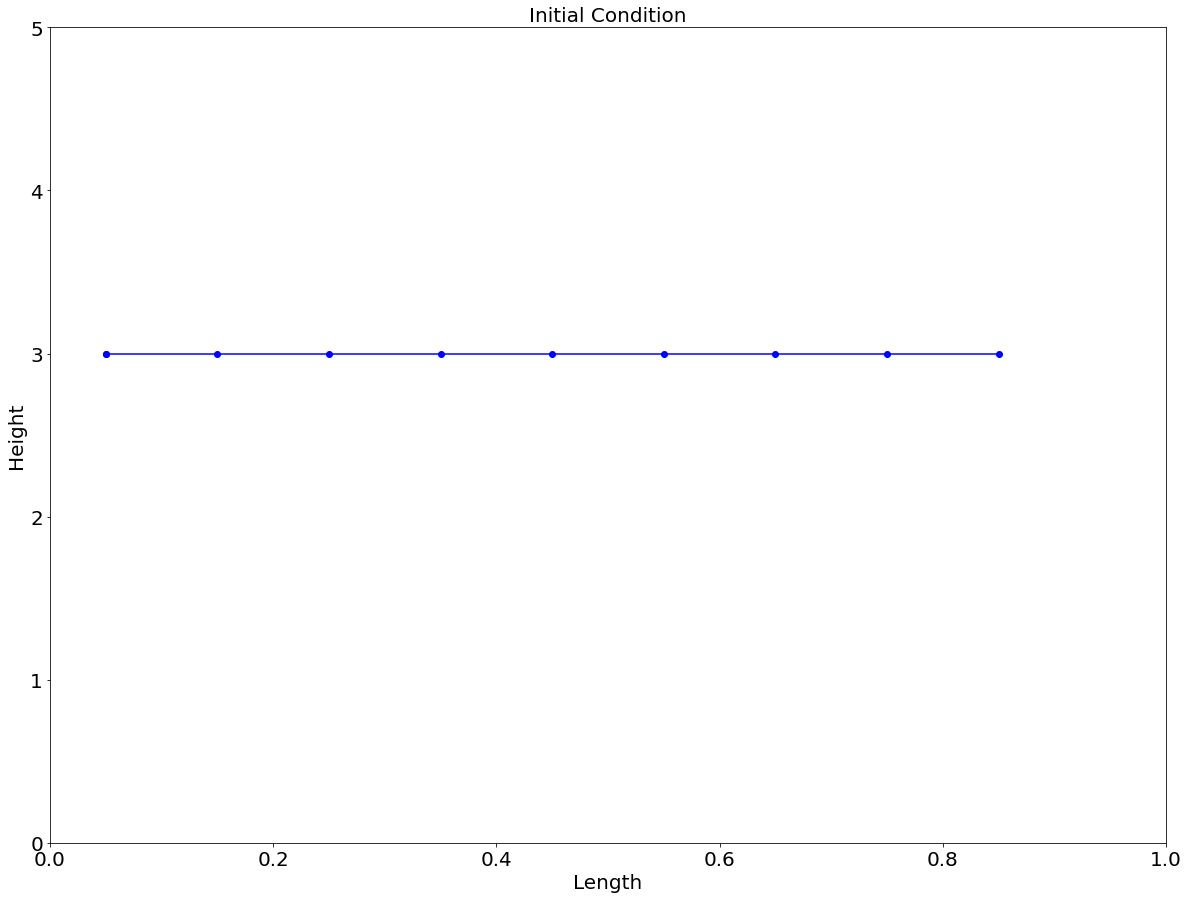

In [26]:
#main driver routine -- 
##--- set up parameter values/initial conditions and call odeint

#parameter values
Npts = 10 #number of points along fly line
t = np.linspace(0.,1.,101) #simulate one second in time in steps of 0.01

L = 0.1*np.ones(Npts) #can read these in too
r = 0.001*np.ones(Npts)
m = 0.001*np.ones(Npts)

#inital conditions
##rod tip
xt = getxt(0) 
yt = getyt(0)
##initial angles/velocities
phi_init = np.zeros((Npts,1))
phidot_init = np.zeros((Npts,1))
##initial solution vector
Yinit = np.append(phi_init,phidot_init)

#plot initial condition
plotdata(phi_init,L,xt,yt,"Initial Condition")

#call odeint
sol = odeint(dYdt,Yinit,t) #solve the system of ODEs

#do stuff with solution - plot, analyze, etc

<module 'matplotlib.pyplot' from 'C:\\Python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

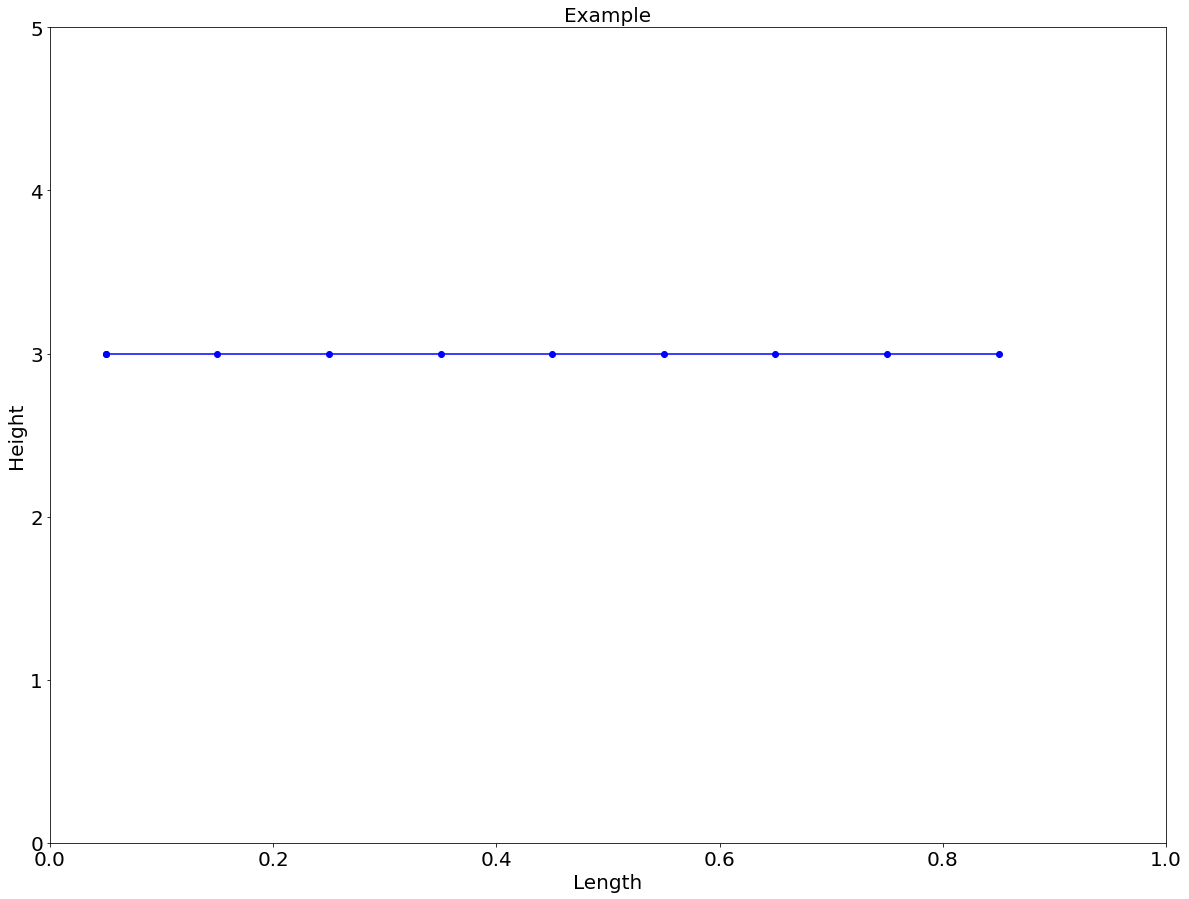

In [27]:
plotdata(sol[0, 0:Npts], L, xt, yt, "Example")

In [30]:
makegif(sol, L, xt, yt)

<Figure size 1440x1080 with 0 Axes>